In [1]:
%env CUDA_PATH=/usr/local/cuda

env: CUDA_PATH=/usr/local/cuda


In [2]:
#export CUDA_PATH=/usr/local/cuda
import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd
from tqdm import trange
import os

from ml_genn import InputLayer, Layer, SequentialNetwork
from ml_genn.callbacks import Checkpoint, SpikeRecorder, VarRecorder, Callback
from ml_genn.compilers import EventPropCompiler, InferenceCompiler
from ml_genn.connectivity import Dense
from ml_genn.initializers import Normal
from ml_genn.neurons import LeakyIntegrate, LeakyIntegrateFire, SpikeInput, LeakyIntegrateFireInput
from ml_genn.optimisers import Adam
from ml_genn.serialisers import Numpy
from ml_genn.synapses import Exponential
from time import perf_counter

from ml_genn.utils.data import (calc_latest_spike_time, linear_latency_encode_data)

from ml_genn.compilers.event_prop_compiler import default_params

import random
import librosa

In [16]:
# constants
params = {}
params["NUM_INPUT"] = 40
params["NUM_HIDDEN"] = 256
params["NUM_OUTPUT"] = 20
params["BATCH_SIZE"] = 128
params["INPUT_FRAME_TIMESTEP"] = 2
params["INPUT_SCALE"] = 0.008
params["NUM_EPOCH"] = 50
params["NUM_FRAMES"] = 80
params["verbose"] = True
params["lr"] = 0.01

#weights
params["hidden_w_mean"] = 0.0 #0.5
params["hidden_w_sd"] = 3.5 #4.0
params["output_w_mean"] = 3.0 #0.5
params["output_w_sd"] = 1.5 #1

file_path = "/its/home/ts468/data/rawHD/experimental_2/"

In [4]:
# change dir for readout files
try:
    os.mkdir("HD_eventprop_output")
except:
    pass

os.chdir("HD_eventprop_output")

# Load testing data
x_train = np.load(file_path + "training_x_data.npy")
y_train = np.load(file_path + "training_y_data.npy")

x_test = np.load(file_path + "testing_x_data.npy")
y_test = np.load(file_path + "testing_y_data.npy")

training_details = pd.read_csv(file_path + "training_details.csv")
testing_details = pd.read_csv(file_path + "testing_details.csv")

training_images = np.swapaxes(x_train, 1, 2) 
testing_images = np.swapaxes(x_test, 1, 2) 

training_images = training_images + abs(np.floor(training_images.min()))
testing_images = testing_images + abs(np.floor(testing_images.min()))

training_labels = y_train
testing_labels = y_test

if params.get("verbose"): print(testing_details.head())
speaker_id = np.sort(testing_details.Speaker.unique())
if params.get("verbose"): print(np.sort(testing_details.Speaker.unique()))

In [5]:
# readout class

class CSVTrainLog(Callback):
    def __init__(self, filename, output_pop, resume):
        # Create CSV writer
        self.file = open(filename, "a" if resume else "w")
        self.csv_writer = csv.writer(self.file, delimiter=",")

        # Write header row if we're not resuming from an existing training run
        if not resume:
            self.csv_writer.writerow(["Epoch", "Num trials", "Number correct", "accuracy", "Time"])

        self.output_pop = output_pop

    def on_epoch_begin(self, epoch):
        self.start_time = perf_counter()

    def on_epoch_end(self, epoch, metrics):
        m = metrics[self.output_pop]
        self.csv_writer.writerow([epoch, 
                                m.total, 
                                m.correct,
                                m.correct / m.total,
                                perf_counter() - self.start_time])
        self.file.flush()
        

In [6]:
# Create sequential model
serialiser = Numpy("latency_hd_checkpoints")
network = SequentialNetwork(default_params)
with network:
    # Populations
    input = InputLayer(LeakyIntegrateFireInput(v_thresh=4,
                                            tau_mem=10, 
                                            input_frames=params.get("NUM_FRAMES"), 
                                            input_frame_timesteps=params.get("INPUT_FRAME_TIMESTEP")),
                        params.get("NUM_INPUT"), 
                        record_spikes = True)
    
    hidden = Layer(Dense(Normal(mean = params.get("hidden_w_mean"), # m = .5, sd = 4 ~ 68%
                                sd = params.get("hidden_w_sd"))), 
                LeakyIntegrateFire(v_thresh=5.0, 
                                    tau_mem=20.0,
                                    tau_refrac=None),
                params.get("NUM_HIDDEN"), 
                Exponential(5.0), #5
                record_spikes=True)
    
    output = Layer(Dense(Normal(mean = params.get("output_w_mean"), # m = 0.5, sd = 1 @ ~ 66
                                sd = params.get("output_w_sd"))),
                LeakyIntegrate(tau_mem=20.0, 
                                readout="avg_var"),
                params.get("NUM_OUTPUT"), 
                Exponential(5.0), #5
                record_spikes=True)

In [7]:
compiler = EventPropCompiler(example_timesteps = params.get("NUM_FRAMES") * params.get("INPUT_FRAME_TIMESTEP"),
                        losses="sparse_categorical_crossentropy",
                        optimiser=Adam(params.get("lr")), batch_size = params.get("BATCH_SIZE"))


compiled_net = compiler.compile(network)

with compiled_net:
    # Evaluate model on numpy dataset
    start_epoch = 0
    callbacks = ["batch_progress_bar", 
                Checkpoint(serialiser), 
                CSVTrainLog("train_output.csv", 
                            output,
                            False),
                SpikeRecorder(hidden, key = "hidden_spike_counts", record_counts = True)]
        
    metrics, cb_data_training  = compiled_net.train({input: training_images * params.get("INPUT_SCALE")},
                                    {output: training_labels},
                                    num_epochs = params.get("NUM_EPOCH"), 
                                    shuffle=True,
                                    #validation_split = 0.1,
                                    callbacks = callbacks)

./EventPropCompiler_CODE/synapseUpdateCUDAOptim.cc(59): warning #177-D: variable "shLg" was declared but never referenced

./EventPropCompiler_CODE/neuronUpdateCUDAOptim.cc(190): warning #177-D: variable "lYTrue" was declared but never referenced

./EventPropCompiler_CODE/customUpdateCUDAOptim.cc(423): warning #177-D: variable "batchOffset" was declared but never referenced

./EventPropCompiler_CODE/synapseUpdateCUDAOptim.cc(59): warning #177-D: variable "shLg" was declared but never referenced

./EventPropCompiler_CODE/neuronUpdateCUDAOptim.cc(190): warning #177-D: variable "lYTrue" was declared but never referenced

./EventPropCompiler_CODE/customUpdateCUDAOptim.cc(423): warning #177-D: variable "batchOffset" was declared but never referenced



swig/python detected a memory leak of type 'CodeGenerator::CUDA::Backend *', no destructor found.
make: Entering directory '/its/home/ts468/PhD/Intel-Neuromorphic-Research-Project/HD_eventprop_output/EventPropCompiler_CODE'


synapseUpdate.cc(59): warning #177-D: variable "shLg" was declared but never referenced

neuronUpdate.cc(190): warning #177-D: variable "lYTrue" was declared but never referenced

customUpdate.cc(423): warning #177-D: variable "batchOffset" was declared but never referenced



make: Leaving directory '/its/home/ts468/PhD/Intel-Neuromorphic-Research-Project/HD_eventprop_output/EventPropCompiler_CODE'


/its/home/ts468/PhD/pythonenv/genn_4_8_1/ve/genn_4_8_1/lib/python3.8/site-packages/tqdm-4.65.0-py3.8.egg/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Epoch 49: 100%|██████████| 64/64 [00:00<00:00, 91.28it/s, SparseCategoricalAccuracy: 0.8605]


In [8]:
len(cb_data_training["hidden_spike_counts"])

409600

In [9]:
type(cb_data_training["hidden_spike_counts"])

list

In [10]:
os.getcwd()

'/its/home/ts468/PhD/Intel-Neuromorphic-Research-Project/HD_eventprop_output'

In [11]:
with open('hidden_spike_counts.npy', 'wb') as f:
    np.save(f, cb_data_training["hidden_spike_counts"])

In [12]:
# evaluate

network.load((params.get("NUM_EPOCH") - 1,), serialiser)

compiler = InferenceCompiler(evaluate_timesteps = params.get("NUM_FRAMES") * params.get("INPUT_FRAME_TIMESTEP"),
                            reset_in_syn_between_batches=True,
                            batch_size = params.get("BATCH_SIZE"))
compiled_net = compiler.compile(network)

with compiled_net:
    callbacks = ["batch_progress_bar", 
                SpikeRecorder(input, key="input_spikes"), 
                SpikeRecorder(hidden, key="hidden_spikes"),
                SpikeRecorder(output, key="output_spikes"),
                VarRecorder(output, "v", key="v_output")]

    metrics, cb_data = compiled_net.evaluate({input: training_images * params.get("INPUT_SCALE")},
                                            {output: training_labels},
                                            callbacks = callbacks)

./InferenceCompiler_CODE/synapseUpdateCUDAOptim.cc(49): warning #177-D: variable "synBatchOffset" was declared but never referenced

./InferenceCompiler_CODE/synapseUpdateCUDAOptim.cc(49): warning #177-D: variable "synBatchOffset" was declared but never referenced



swig/python detected a memory leak of type 'CodeGenerator::CUDA::Backend *', no destructor found.
make: Entering directory '/its/home/ts468/PhD/Intel-Neuromorphic-Research-Project/HD_eventprop_output/InferenceCompiler_CODE'


synapseUpdate.cc(49): warning #177-D: variable "synBatchOffset" was declared but never referenced



make: Leaving directory '/its/home/ts468/PhD/Intel-Neuromorphic-Research-Project/HD_eventprop_output/InferenceCompiler_CODE'


100%|██████████| 64/64 [00:01<00:00, 34.59it/s, SparseCategoricalAccuracy: 0.8789]


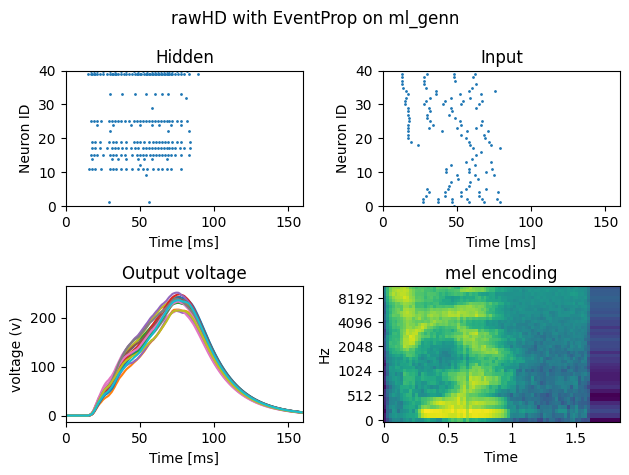

FileNotFoundError: [Errno 2] No such file or directory: 'train_output.csv'

In [17]:
if params.get("verbose"):
    # cannot print verbose whilst requesting just accuracy
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
    fig.suptitle('rawHD with EventProp on ml_genn')

    value = random.randint(0, len(x_test))

    ax1.scatter(cb_data["hidden_spikes"][0][value], 
                cb_data["hidden_spikes"][1][value], s=1)
    ax1.set_xlabel("Time [ms]")
    ax1.set_ylabel("Neuron ID")
    ax1.set_title("Hidden")
    ax1.set_xlim(0, params.get("NUM_FRAMES") * params.get("INPUT_FRAME_TIMESTEP"))
    ax1.set_ylim(0, params.get("NUM_INPUT"))

    ax2.scatter(cb_data["input_spikes"][0][value], 
                cb_data["input_spikes"][1][value], s=1)
    ax2.set_xlabel("Time [ms]")
    ax2.set_ylabel("Neuron ID")
    ax2.set_title("Input")
    ax2.set_xlim(0, params.get("NUM_FRAMES") * params.get("INPUT_FRAME_TIMESTEP"))
    ax2.set_ylim(0, params.get("NUM_INPUT"))

    ax3.plot(cb_data["v_output"][value])
    ax3.set_xlabel("Time [ms]")
    ax3.set_ylabel("voltage (v)")
    ax3.set_title("Output voltage")
    ax3.set_xlim(0, params.get("NUM_FRAMES") * params.get("INPUT_FRAME_TIMESTEP"))
    #ax3.set_ylim(0, params.get("NUM_INPUT"))

    sr = 22050
    img = librosa.display.specshow(x_train[value], 
                            x_axis='time', 
                            y_axis='mel', 
                            sr=sr, 
                            cmap='viridis')
    #fig.colorbar(img, ax = ax4)
    ax4.set_title("mel encoding")

    fig.tight_layout()

    plt.show()
    
    data = pd.read_csv("train_output.csv")
    df = pd.DataFrame(data, columns=['accuracy'])

    accuracy = np.array(df)

    accuracy = accuracy * 100

    validation = []
    training = []

    for i in range(len(accuracy)):
        if i % 2 == 0:
            training.append(float(accuracy[i]))
        else:
            validation.append(float(accuracy[i]))
                        
    plt.plot(training, label = "training")
    plt.plot(validation, label = "validation")
    plt.ylabel("accuracy (%)")
    plt.xlabel("epochs")
    plt.title("accuracy during training")
    plt.legend()
    plt.show()


In [14]:

    

    
    

    


# reset directory

os.chdir("..")
